In [111]:
import wandb
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from matplotlib.ticker import FormatStrFormatter
from scipy.optimize import curve_fit
from scipy.spatial import ConvexHull

api = wandb.Api()
runs = api.runs("shehper/owt-scaling")

In [113]:
def linear_fit(xs, ys):
    # xs, ys may each be a Python list or 1d numpy array of x and y values
    model = LinearRegression()
    model.fit(np.array(xs).reshape(-1, 1), np.array(ys).reshape(-1, 1))
    slope, intercept = model.coef_[0][0], model.intercept_[0]
    return slope, intercept

### Scaling Law with Parameter Count

It was proposed in [1] that the test loss of language models follows a scaling law as a function of the (non-embedding) parameter count $N$ (when trained on large amounts of data):

\begin{equation}
L(N) = \left(\frac{N_c}{N}\right)^{\alpha_N}
\end{equation}

The authors trained a number of models with $N$ varying over six orders in magnitude (from $10^4$ to $10^9$). We reproduced their trend after training a fewer number of models due to computational constraints. We varied $N$ over three orders of magnitude ($10^5$ to $10^7$). The trend in equation (1) already manifested itself at this scale. A comparison of our values for $N_c$ and $\alpha_N$ with those of [1] is given in the table below. 


<center>

|                   | $N_c$ | $\alpha_N$ | 
| :---------------- | :------: | ----: | 
| Kaplan et al.        |   $8.8 \times 10^{13}$   | $0.076$ |  
| My results           |   $3.81 \times 10^{13}$  | $0.082$ |  

</center>

Scaling law with N: L(N)= (N/3.81e+13)^-0.0823


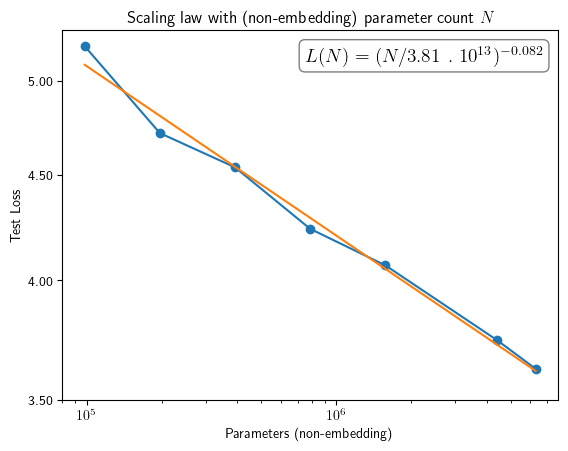

In [215]:
# obtain a list of tuples (N, loss) from runs with scale_N = True
loss_v_N = sorted(
    [
        (run.config["N"], run.summary["val/loss"])
        for run in runs
        if run.config["scale_N"]
    ]
)
Ns = [N for (N, _) in loss_v_N]
losses = [loss for (_, loss) in loss_v_N]

# Fit to the equation in log-space: log(L) = alpha_N log(N_c) - alpha_N log(N)
slope, intercept = linear_fit(np.log(Ns), np.log(losses))
alpha_N, N_c = -slope, np.exp(-intercept / slope)
print(f"Scaling law with N: L(N)= (N/{N_c:.2e})^{-alpha_N:.4f}")
textLN = "$L(N) = (N/{0} \ . \ 10^{{{1}}})^{{{2}}}$".format(
    *f"{N_c:.2e}".split("e+") + [f"{-alpha_N:.3f}"]
)

# plt.figure(dpi=1200)
# Plot the data and fit
plt.plot(Ns, losses, "-o")
plt.plot(Ns, (N_c / np.array(Ns)) ** alpha_N, "-")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Parameters (non-embedding)")
plt.ylabel("Test Loss")
plt.yticks(np.arange(3.5, 5.25, 0.5))
plt.gca().yaxis.set_major_formatter(FormatStrFormatter("%.2f"))
plt.text(
    7.5e5,
    5.2,
    textLN,
    verticalalignment="top",
    fontsize=14,
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.5),
)
plt.title("Scaling law with (non-embedding) parameter count $N$")
# plt.savefig('./assets/Kaplan_N.png')
plt.show()

### Scaling Law with Parameter Count and Dataset Size

If we vary the dataset size $D$ along with the model size $N$, the test loss follows the following trend [1].  

\begin{equation}
L(N, D) = \left[ \left(\frac{N_c}{N}\right)^{\frac{\alpha_N}{\alpha_D}} + \frac{D_c}{D}\right]^{\alpha_D}
\end{equation}

In [1], the authors varied N over five orders of magnitude ($10^5$ to $10^9$) and $D$ over three orders of magnitude ($10^{8}$ to $10^{10}$), and found the empirical results to be consistent with this equation. 

We performed the analysis on a smaller scale: varying $N$ over two orders of magnitude ($10^5$ to $10^6$) and $D$ over three orders of magnitude ($10^7$ to $10^{10}$ tokens). We obtained good fits to the equation (see the plots below) with constants given in the following table.

<center>

|                   | $N_c$ | $\alpha_N$ | $D_c$ | $\alpha_D$ | 
| :---------------- | :------: | ----: | :------: | ----: |
| Kaplan et al.        |   $6.4 \times 10^{13}$   | $0.076$ |   $1.8 \times 10^{13}$  | $0.103$ |
| Our results           |   $1.32 \times 10^{14}$  | $0.076$ |   $1.22 \times 10^{12}$   | $0.122$ 

</center>

The difference between our fit and that of [1] could be because of one or more of the following reasons.

1. *Different datasets.* The authors of [1] used WebText2 dataset; we used the OpenWebText dataset.  

2. *Different number of training steps*. We trained all models for $2.5 \times 10^5$ iterations; the authors of [1] trained all models to full convergence. 

3. *Number of training runs*. We ran much fewer experiments compared to [1]. 

In [216]:
## Fit data to L(N, D)
# obtain a list with tuples (N, D, loss) for runs with scale_D=Kaplan and D > 1e7
# see the end of this section for the reason why we resstrict to D > 1e7 here
loss_v_N_D = [
    (run.config["N"], run.config["D"], run.summary["val/loss"])
    for run in runs
    if run.config["scale_D"] and run.config["D"] > 1e7
]
Ns = [N for (N, _, _) in loss_v_N_D]
Ds = [D for (_, D, _) in loss_v_N_D]
losses = [loss for (_, _, loss) in loss_v_N_D]


# define L(N, D)
def L(input, D_c, alpha_D, N_c, alpha_N):
    N, D = input  # input is a tuple or a list of two ints N and D
    exp = (N_c / N) ** (alpha_N / alpha_D) + (
        D_c / D
    )  # expression enclosed inside [...]^\alpha_D
    return np.sign(exp) * np.abs(exp) ** alpha_D


# Use scipy.optimize.curve_fit with initial guess p0 to fit data.
# Use N_c and alpha_N obtained above in fit to L(N) as initial guesses.
# Give a guess close to the order of magnitude of the expected result for D_c and alpha_D.
(D_c, alpha_D, N_cp, alpha_Np), _ = curve_fit(
    L, (Ns, Ds), losses, maxfev=50000, p0=[1e10, 1, 3e13, 0.08]  # inputs  # outputs
)

print(f"alpha_N: {alpha_Np:.4f}, alpha_D: {alpha_D:.4f}")
print(
    f"Scaling law with N and D: L(N, D)=[({N_cp:.2e}/N)^{(alpha_Np/alpha_D):.4f} + ({D_c:.2e}/D)]^{alpha_D:.4f}"
)

alpha_N: 0.0763, alpha_D: 0.1224
Scaling law with N and D: L(N, D)=[(1.32e+14/N)^0.6236 + (1.22e+12/D)]^0.1224


<Figure size 7680x5760 with 0 Axes>

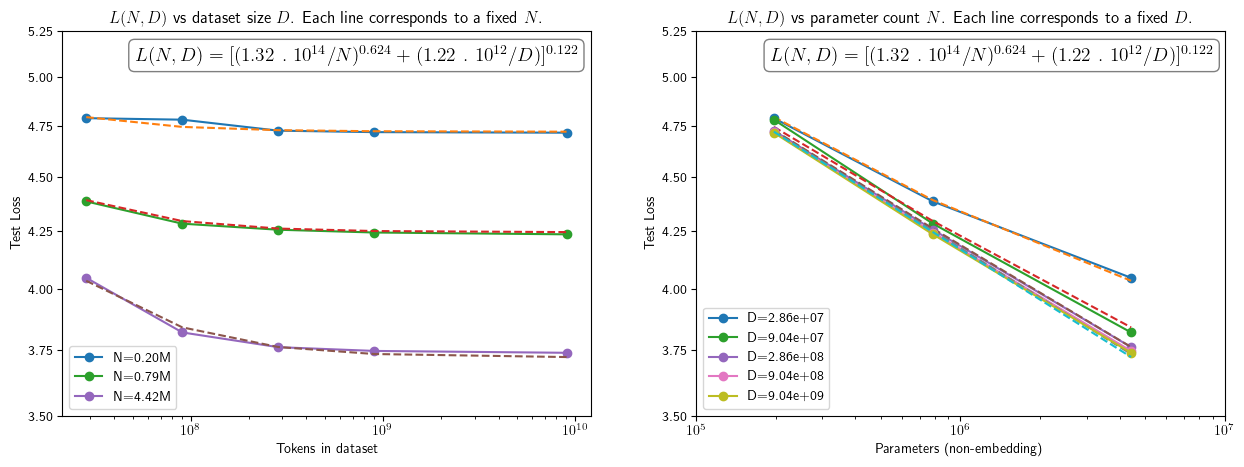

In [217]:
## plot the data and fits
plt.figure(dpi=1200)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# plot L(N, D) as a function of D for each fixed value of N
for N in sorted(list(set(Ns))):
    # get a list of (D, loss) values at fixed N, and sort it
    relevant_loss_v_D = [
        (D, loss) for i, (D, loss) in enumerate(zip(Ds, losses)) if Ns[i] == N
    ]
    relevant_loss_v_D.sort()

    # plot the data points
    ax1.plot(
        [D for (D, _) in relevant_loss_v_D],
        [loss for (_, loss) in relevant_loss_v_D],
        "-o",
        label=f"N={N/1e6:.2f}M",
    )

    # estimate L(N, D) from the learned equation above and plot it
    fit_output = L(
        (N, [D for (D, _) in relevant_loss_v_D]), D_c, alpha_D, N_cp, alpha_Np
    )
    ax1.plot([D for (D, _) in relevant_loss_v_D], fit_output, "--")


# plot L(N, D) as a function of N for each fixed value of D.
for D in sorted(list(set(Ds))):
    # get a list of (N, loss) values at fixed D, and sort it
    relevant_loss_v_N = [
        (N, loss) for i, (N, loss) in enumerate(zip(Ns, losses)) if Ds[i] == D
    ]
    relevant_loss_v_N.sort()

    # plot the data points
    ax2.plot(
        [N for (N, _) in relevant_loss_v_N],
        [loss for (_, loss) in relevant_loss_v_N],
        "-o",
        label=f"D={D:.2e}",
    )

    # estimate L(N, D) from the learned equation above and plot it
    fit_output = L(
        ([N for (N, _) in relevant_loss_v_N], D), D_c, alpha_D, N_cp, alpha_Np
    )
    ax2.plot([N for (N, _) in relevant_loss_v_N], fit_output, "--")

textLND = "$L(N, D) = [({0} \ . \ 10^{{{1}}}/N )^{{{2}}} + \
            ({{{3}}} \ . \ 10^{{{4}}}/D) ]^{{{5}}}$".format(
    *f"{N_cp:.2e}".split("e+")
    + [f"{alpha_Np/alpha_D:.3f}"]
    + f"{D_c:.2e}".split("e+")
    + [f"{alpha_D:.3f}"]
)
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_xlabel("Tokens in dataset")
ax1.set_ylabel("Test Loss")
ax1.legend(loc="lower left")
ax1.set_yticks(np.arange(3.5, 5.5, 0.25))
ax1.yaxis.set_major_formatter(FormatStrFormatter("%.2f"))
ax1.text(
    5.1e7,
    5.17,
    textLND,
    verticalalignment="top",
    fontsize=14,
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.5),
)
ax1.set_title("$L(N, D)$ vs dataset size $D$. Each line corresponds to a fixed $N$.")

ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_xlabel("Parameters (non-embedding)")
ax2.set_ylabel("Test Loss")
ax2.legend(loc="lower left")
ax2.set_yticks(np.arange(3.5, 5.5, 0.25))
ax2.yaxis.set_major_formatter(FormatStrFormatter("%.2f"))
ax2.set_xticks([10**5, 10**6, 10**7])
ax2.text(
    1.9e5,
    5.17,
    textLND,
    verticalalignment="top",
    fontsize=14,
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.5),
)
ax2.set_title("$L(N, D)$ vs parameter count $N$. Each line corresponds to a fixed $D$.")
plt.savefig("./assets/Kaplan_ND.png")
plt.show()

We observe very good fits to $L(N, D)$. Note that the plots at fixed $D$ are nearly linear. This is expected as we vary $N$ over only two orders of magnitude. By including more values of $N$, we expect the plots to show more curvature. 

We remark that the fit to $L(N, D)$ is not good if we include the cases with $D < 10^7$. (We performed some experiments with $D \sim 10^6$. To see how badly they affect the fit to L(N, D), remove the condition D < 1e7 in the definition of loss_v_N_D above.) This was already pointed in [1] with a plausible explanation: for such small values of $D$, overfitting happens quite early in training, and perhaps, these cases lie in a different regime of language modeling.

### Scaling Laws with Compute

The experiments used to study scaling laws for $L(N)$ and $L(N, D)$ may be used to obtain a scaling law with total compute $C = 6 N E$. Here, $E$ is the total number of training examples processed during training. It depends on batch size (equivalently, the number of tokens processed in each training step) $B$ and the number of training steps $S$ as $E = BS$. 

In [1], the authors find 

\begin{equation}
L(C) = \left(\frac{C_c}{C}\right)^{\alpha_C}
\end{equation}

For each value of $C$, they also found the optimal number of non-embedding parameters $N_{\text{opt}}$ that gives the lowest test loss. $N_{\text{opt}}$ follows the following trend:

\begin{equation}
N_{\text{opt}}(C) = N_e C^{p_N} 
\end{equation}

They varied $C$ over eight orders of magnitude ($10^{-9}$ to $10^{-1}$ PF-days). We performed experiments at a much smaller scale, covering only three orders of magnitude ($10^{-5}$ to $10^{-3}$ PF-days). A comparison of our results with those of [1] is given in the table below. 

<center>

|                   | $C_c$ | $\alpha_C$ | $N_e$ | $p_N$ | 
| :---------------- | :------: | ----: | :------: | ----: |
| Kaplan et al.        |   $1.6 \times 10^{7}$   | $0.057$ |   $1.6 \times 10^{9}$  | $0.88$ |
| My results           |   $1.8 \times 10^{5}$  | $0.074$ |   $2.8 \times 10^{9}$   | $0.90$ 

</center>

Note that while our fit to $L(C)$ is significantly different from that of [1], our fit to $N_{\text{opt}}(C)$ is similar. We suspect that this is because while the loss value for a given compute depends on the dataset used to train a model, the optimal number of parameters for a given compute depends only on the training configuration. This hypothesis may be verified by running our analysis on other datasets.

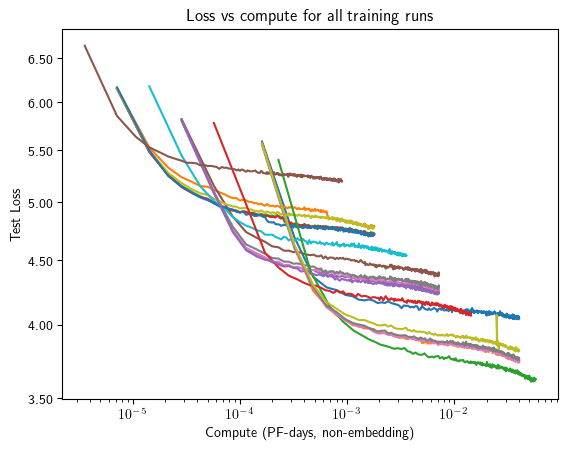

In [153]:
# plot validation loss vs compute for all runs
loss_v_C_runs = [
    run
    for run in runs
    if (run.config["scale_N"] or run.config["scale_D"]) and run.config["D"] > 1e7
]

# loss_v_C is a dictionary with key = (N, D) to specify a run, val = tuple of lists ([..], [..])
# The first list contains compute values, the second list contains losses
loss_v_C = {}
for run in loss_v_C_runs:
    N, D = run.config["N"], run.config["D"]
    tokens_per_iter = (
        run.config["batch_size"]
        * run.config["gradient_accumulation_steps"]
        * run.config["block_size"]
    )
    run_history = [row for row in run.scan_history()]
    loss_v_C[(N, D)] = (
        [
            6 * N * step["iter"] * tokens_per_iter / 8.64e19 for step in run_history[1:]
        ],  # divide by 8.64e19 for PF-days
        [step["val/loss"] for step in run_history[1:]],
    )
    plt.plot(loss_v_C[(N, D)][0], loss_v_C[(N, D)][1])  # plot (Cs, losses) for the run

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Compute (PF-days, non-embedding)")
plt.ylabel("Test Loss")
plt.yticks(np.arange(3.5, 7.0, 0.5))
plt.gca().yaxis.set_major_formatter(FormatStrFormatter("%.2f"))
plt.title("Loss vs compute for all training runs")
plt.show()

Now we model minimum loss $L$ and optimal model size $N_{\text{opt}}$ as functions of compute $C$. If we were to naively consider the whole range of compute shown in the plot above, our results will be incorrect as for large computes (roughly > $10^{-3}$ PF-days), we must include experiments with larger models to obtain the minimum possible loss. Similarly, to obtain the best performance at small values of compute (roughly < $10^{-5}$ PF-days), smaller models must be trained. Therfore, we will restrict our analysis to a smaller range of compute values. By visual inspection of the plot above, we choose $10^{-5}$ to $10^{-3}$ PF-days as this range seems to have enough number of training curves and some clear minimum values. 

To find the minimum loss as a function of $C$, we find the convex hull of all data points in the plot above and restrict to those in the range $10^{-5} < C < 10^{-3}$.

In [218]:
## find the scaling law L(C) and Nopt(C)
# minloss_v_C is a dict with key=C, val=minimum loss achieved with that C.
# Nopts_v_C is a dict with key=C, val=optimal value of N for that C.
minloss_v_C = {}
Nopts_v_C = {}
for (N, D), (Cs, losses) in loss_v_C.items():
    for C, loss in zip(Cs, losses):
        if C not in minloss_v_C:
            minloss_v_C[C] = loss
            Nopts_v_C[C] = N
        else:
            if loss < minloss_v_C[C]:
                minloss_v_C[C] = loss
                Nopts_v_C[C] = N

# Get points on the convex hull of minloss vs C plot.
points = np.array([(C, minloss) for C, minloss in minloss_v_C.items()])
hull = ConvexHull(points)  # compute the convex hull of all (C, minloss) points
# hull.simplices contains the end points of each simplex
# obtain all points on the edges of simplices in hull_points
hull_points = sorted(
    list(set([tuple(points[simplex[i]]) for i in [0, 1] for simplex in hull.simplices]))
)

## Train a Linear Regression model on (C, minloss) points on the convex hull
# first, obtain x and y coordinates for points on the convex hull, restricting to range 1e-5 < C < 1e-3
hull_Cs = [C for (C, _) in hull_points if 1e-5 < C < 1e-3]
hull_losses = [loss for (C, loss) in hull_points if 1e-5 < C < 1e-3]
slope, intercept = linear_fit(np.log(hull_Cs), np.log(hull_losses))
alpha_C, C_c = -slope, np.exp(-intercept / slope)
print(f"Our scaling law with C: L(C)=(C/{C_c:.2e})^{-alpha_C:.4f}")

## Now train a Linear Regression model on (C, N_{opt}) using points on the convex hull
hull_Ns = [Nopts_v_C[C] for C in hull_Cs]
slope, intercept = linear_fit(np.log(hull_Cs), np.log(hull_Ns))
p_N, N_e = slope, np.exp(intercept)
print(f"Our scaling law for Nopt as a function of C: N(C) = {N_e:.2e} C^{p_N:.4f}")

Our scaling law with C: L(C)=(C/1.08e+05)^-0.0745
Our scaling law for Nopt as a function of C: N(C) = 2.81e+09 C^0.8967


<Figure size 7680x5760 with 0 Axes>

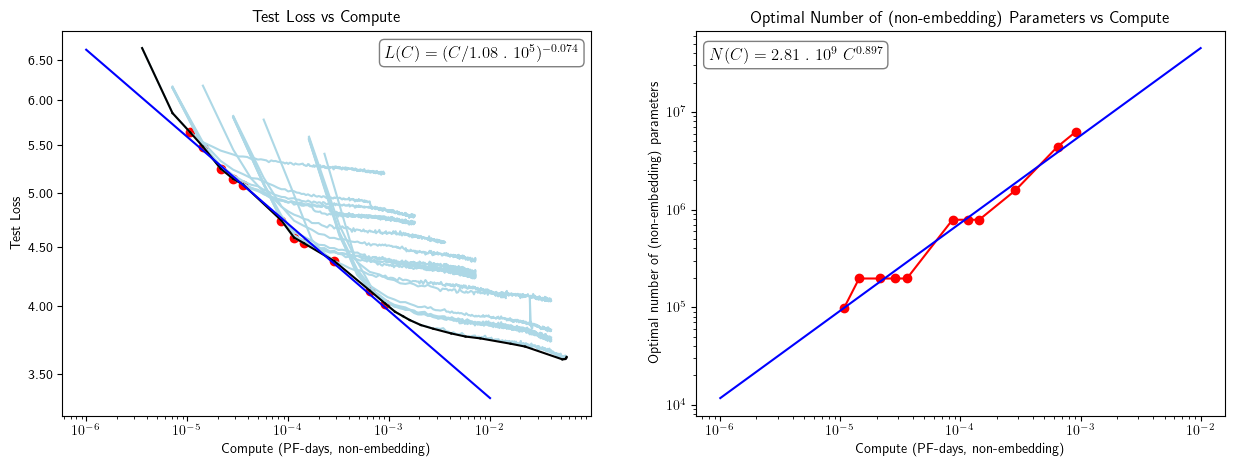

In [219]:
## plot the two fits to scaling laws
plt.figure(dpi=1200)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

####### ------ PLOT LOSS-C WITH AX1 --------- ###########

# plot all the loss-C curves in light blue
for Cs, losses in loss_v_C.values():
    ax1.plot(Cs, losses, color="lightblue")

# plot all the simplices in black
for simplex in hull.simplices[1:]:
    ax1.plot(points[simplex, 0], points[simplex, 1], color="black")

# plot all points used for the linear fit in red
ax1.scatter(hull_Cs, hull_losses, color="red")

# plot the linear fit in blue
domain = [10 ** (-n) for n in range(2, 7)]
ax1.plot(domain, (C_c / np.array(domain)) ** alpha_C, "-", color="blue")

####### ------ PLOT NOPT-C WITH AX1 --------- ###########
# plot all points used for linear fit in red
ax2.plot(hull_Cs, hull_Ns, "-o", color="red")

# plot the linear fit in blue
ax2.plot(domain, N_e * (np.array(domain) ** p_N), "-", color="blue")

##### --------- SETTING CONFIGURATIONS -------- ############
textLC = "$L(C) = (C/{0} \ . \ 10^{{{1}}})^{{{2}}}$".format(
    *f"{C_c:.2e}".split("e+0") + [f"{-alpha_C:.3f}"]
)
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_xlabel("Compute (PF-days, non-embedding)")
ax1.set_ylabel("Test Loss")
ax1.set_yticks(np.arange(3.5, 7.0, 0.5))
ax1.yaxis.set_major_formatter(FormatStrFormatter("%.2f"))
ax1.text(
    9e-4,
    6.70,
    textLC,
    verticalalignment="top",
    fontsize=12,
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.5),
)
ax1.set_title("Test Loss vs Compute")

textNC = "$N(C) = {0} \ . \ 10^{{{1}}} \ C^{{{2}}}$".format(
    *f"{N_e:.2e}".split("e+0") + [f"{p_N:.3f}"]
)
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_xlabel("Compute (PF-days, non-embedding)")
ax2.set_ylabel("Optimal number of (non-embedding) parameters")
ax2.text(
    8e-7,
    4.7e7,
    textNC,
    verticalalignment="top",
    fontsize=12,
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.5),
)
ax2.set_title("Optimal Number of (non-embedding) Parameters vs Compute")

# save each subplot separately
extent = ax1.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig("./assets/Kaplan_LC.png", bbox_inches=extent.expanded(1.2, 1.25))

# save each subplot separately
extent = ax2.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig("./assets/Kaplan_NC.png", bbox_inches=extent.expanded(1.2, 1.25))

plt.show()

### Computation of Critical Batch Size

In all our experiments, we trained at a fixed batch size of $2^{19} \sim 0.5 \times 10^6$ tokens per training step. This batch size might not be optimal for making use of our computational resources and training time. In [2], the authors proposed a 'critical batch size' $\mathcal{B}_{\text{crit}}$, and argued that training at batch sizes greater than (smaller than) this batch size makes a waste of computational resources (training time). 

If $2^{19}$ is larger than the critical batch size (which we will soon see is the case), we have wasted some valuable computational resources. In the future, we can train our models below the critical batch size to avoid this waste, but then its test loss will not follow the trend predicted by $L(C)$. In this section, we compute the critical batch size; in the next section, we will use its value to adjust our scaling laws with compute.

The critical batch size $\mathcal{B}_{\text{crit}}$ was defined in [2] by finding a fit to the following equation

\begin{equation}
\left(\frac{S}{S_{\text{min}}} - 1 \right) \left( \frac{E}{E_{\text{min}}} - 1 \right) = 1
\end{equation}

where $S$ is the number of training steps and $E$ is the number of training examples processed to achieve a specific level of performance (for example, a specified value of training loss). Note that $E=BS$ as we train at a fixed number of training examples per training step. $S_{\text{min}}$ is the minimum number of training steps (in a maximally time-efficient training run) and $E_{\text{min}}$ is the minimum number of training examples (in a maximally compute-efficient training run) that the model will need to obtain the same level of performance.

The critical batch size is defined to be the batch size at which a specified trade-off between compute-efficiency and time-efficiency occurs: it requires $2E_{\text{min}}$ examples and $2S_{\text{min}}$ training steps to obtain the desired level fo performance. Mathematically, $2E_{\text{min}} = \mathcal{B}_{\text{crit}} (2 S_{\text{min}})$, or

\begin{equation}
\mathcal{B}_{\text{crit}} \equiv \frac{E_{\text{min}}}{S_{\text{min}}}
\end{equation}

$\mathcal{B}_{\text{crit}}$ is a function of the trianing loss $L$, but is largely independent of the model size $N$ used to estimate $S_{\text{min}}$ and $E_{\text{min}}$ [2]. In [1], its dependence on $L$ was shown to have the following form for a GPT model:

\begin{equation}
\mathcal{B}_{\text{crit}} \approx \frac{B_{\star}}{L^{1/\alpha_B}}
\end{equation}

We will find $\mathcal{B}_{\text{crit}}$ as follows. For a specified loss value, we will measure $S$ and $E$ at a range of batch sizes. Then we will use this data to find a fit to equation (1), thus estimating $S_{\text{min}}$ and $E_{\text{min}}$. Finally, we will show that $\mathcal{B}_{\text{crit}} \equiv \frac{E_{\text{min}}}{S_{\text{min}}}$ follows the trend in equation (3). A comparison of our results for $B_\star$, $\alpha_B$ to that of [1] is given in the table below.

<center>

|                   | $B_\star$ | $\alpha_B$ | 
| :---------------- | :------: | ----: | 
| Kaplan et al.        |   $2.0 \times 10^8$   | $0.21$ |  
| My results           |   $2.2 \times 10^7$  | $0.23$ |  

</center>

We make some remarks about our experimental setup and its comparison with the details provided in [1] and [2].

1. In order to vary batch size, one may vary the length of the context window (that is, block size in nanoGPT) or the number of training sequences per training step (that is, batch size * gradient accumulation steps in nanoGPT). We keep the former fixed at 1024, varying the latter to take one the following values: [2, 4, 16, 64, 128]. At each batch size, we run three experiments with learning rates 1e-2, 1.2e-3, and 1e-4. The number of training steps $S$ and the number of examples $E$ at a batch size are taken to be the minimum values of these variables amongst all the runs with that fixed batch size (but different learning rates). This setup roughly follows the guidelines provided in Appendix A of [2]. 

2. We logged training loss after every five training steps. One may expect to get slighly better estimates of $S_{\text{min}}$ and $E_{\text{min}}$ if the training loss is logged more frequently.

3. We smooth all our training loss curves using exponential moving average with the smoothing factor 0.99. The authors of [2] also used EMA to smooth their loss curves, but they do not specify the smoothing factor used for it in [1] or [2]. 

4. We conducted all of our experiments with a model of size 157K. In contrast, the experiments of [1] were done using models with 3M and 44M parameters. Critical batch size is expected to be largely independent of the model size, depending on it only through the value of the target loss [2]. Nevertheless, this difference might have had a small impact on our results. 

5. Our fits to equation (1) can be improved. We used scipy.optimize.curve_fit to find these fits. Perhaps a different algorithm will give better fits than those we obtained.

6. The specified values of training loss over which we measure $S$ and $E$ range from 9.0 to 5.9. In contrast, a larger range of values from 10.0 to 3.0 was considered in [1]. (See figure 10 in their paper.) This is because of the difference in model sizes mentioned above. As a result, we see $S$ and $E$ varied over only three orders of magnitude, while the authors of [1] varied $S$ and $E$ over six orders of magnitude. (See Figure 18 in the paper.)

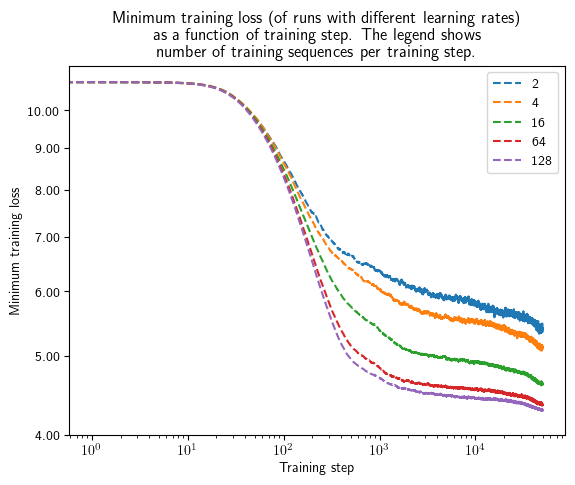

In [220]:
# compute exponential moving average of a list of numbers x; returns another list y
def ema(x, a=0.99):
    y = [0] * len(x)
    y[0] = x[0]
    for k in range(1, len(x)):
        y[k] = y[k - 1] * a + x[k] * (1 - a)
    return y


# obtain a dictionary losses_v_batch with key = number of training sequences per training step (n_seq)
# val = list; ith element is the minimum training loss obtained at training step=5i amongst all
# runs with batch size = n_seq.
# The code in this cell could be sped up. However, I have left it as it is. It takes 5-6 minutes on a macbook Air to process.
losses_v_batch = {}
for run in runs:
    if run.config["estimate_B_crit"]:
        n_seq = (
            run.config["batch_size"] * run.config["gradient_accumulation_steps"]
        )  # number of training sequences per training step
        loss_hist = ema(
            [row["iter_loss"] for row in run.scan_history()]
        )  # history of exponential moving averaged losses
        if n_seq not in losses_v_batch.keys():
            losses_v_batch[n_seq] = loss_hist
        else:
            losses_v_batch[n_seq] = [
                min(losses_v_batch[n_seq][i], loss_hist[i])
                for i in range(len(loss_hist))
            ]

for n_seq, loss_hist in sorted(losses_v_batch.items()):
    plt.plot(list(range(len(loss_hist))), loss_hist, "--", label=f"{n_seq}")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Training step")
plt.ylabel("Minimum training loss")
plt.yticks(np.arange(4.00, 11.00, 1.0))
plt.gca().yaxis.set_major_formatter(FormatStrFormatter("%.2f"))
plt.title(
    "Minimum training loss (of runs with different learning rates) \n"
    "as a function of training step. The legend shows \n"
    "number of training sequences per training step."
)
plt.legend()
plt.show()

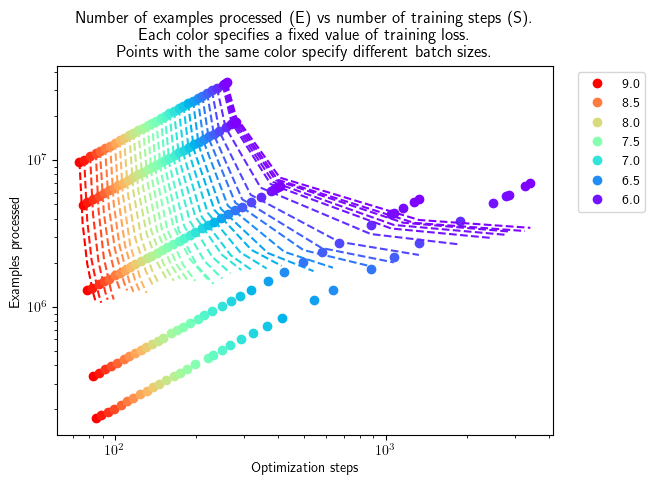

In [221]:
## Collect E vs S data and fit this data to the equation (S/Smin - 1) (E/Emin - 1) = 1
# Choose a set of losses at which S and E will be measured
losses = [9.0 - 0.1 * i for i in range(30) if 9 - 0.1 * i > 6.0] + [
    6.0 - 0.02 * i for i in range(5) if 6 - 0.02 * i > 5.90
]

# collect data of E vs S in dict e_v_s.
# key: loss, val: a dict with keys: steps, examples.
# dict['steps'] (dict['examples']) contains the minimum number of steps (examples) to obtain that loss
e_v_s = {loss: {"steps": [], "examples": []} for loss in losses}
for n_seq in losses_v_batch.keys():
    i = 0
    for step, iter_loss in enumerate(losses_v_batch[n_seq]):
        if iter_loss < losses[i]:
            if (
                i < len(losses) - 1 and iter_loss < losses[i + 1]
            ):  # its actually less than the next loss as well
                raise Exception(
                    f"increase the difference between losses[{i}]={losses[i]} and losses[{i+1}]={losses[i+1]} as iter_loss is lesser than both"
                )
            e_v_s[losses[i]]["steps"] += [step]
            e_v_s[losses[i]]["examples"] += [step * n_seq * 1024]
            i += 1
        if i == len(losses):
            break
    if i < len(losses):
        raise Exception(
            f"for n_seq = {n_seq}, minimum loss obtained is bigger than min(losses)"
        )


# define E as a function of S (steps) with constants step_min, e_min to be determined
def fit(steps, step_min, e_min):
    return e_min * (1 + step_min / (steps - step_min + 1e-7))


# define critical batch as a function of loss and fit to data using curve_fit
critical_bs = {loss: 0.0 for loss in losses}  # loss: (step_min, e_min)
cmap = plt.cm.rainbow
norm = matplotlib.colors.Normalize(vmin=min(losses), vmax=max(losses))
for loss, s_e_dict in e_v_s.items():
    steps, examples = s_e_dict["steps"], s_e_dict["examples"]
    (step_min, e_min), _ = curve_fit(
        fit,
        steps,
        examples,
        maxfev=500000,
        p0=[min(steps) - 1e-7, min(examples) - 1e-7],
    )
    critical_bs[loss] = e_min / step_min
    plt.plot(steps, examples, "o", color=cmap(norm(loss)), label=f"{loss}")
    plt.plot(steps, fit(steps, step_min, e_min), "--", color=cmap(norm(loss)))

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Optimization steps")
plt.ylabel("Examples processed")
plt.title(
    "Number of examples processed (E) vs number of training steps (S).\n"
    "Each color specifies a fixed value of training loss. \n"
    "Points with the same color specify different batch sizes."
)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels[::5], handles[::5]))
plt.legend(
    by_label.values(), by_label.keys(), loc="upper right", bbox_to_anchor=(1.2, 1.0)
)
plt.show()

alpha_B: 0.2346
Scaling Law of Critical Batch Size with Train Loss: B_crit(L) = 2.20e+07 L^-4.2627


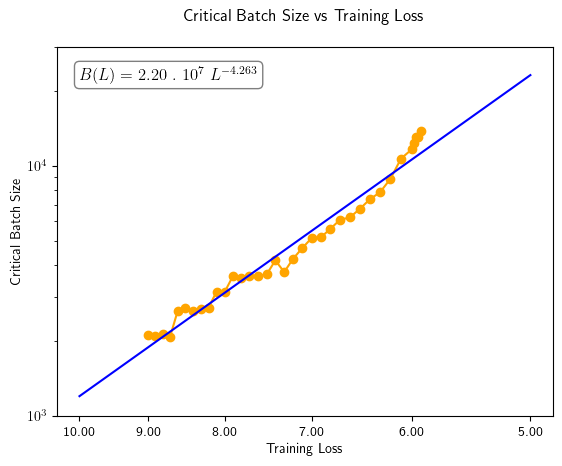

In [265]:
## Collect data of (loss, Bcrit) and perform a fit to Bcrit(L).
losses, bs = [], []
for loss, b in critical_bs.items():
    losses.append(loss)
    bs.append(b)

slope, intercept = linear_fit(np.log(losses), np.log(bs))
alpha_B, Bstar = -1 / slope, np.exp(intercept)
print(f"alpha_B: {alpha_B:.4f}")
print(
    f"Scaling Law of Critical Batch Size with Train Loss: B_crit(L) = {Bstar:.2e} L^{-1/alpha_B:.4f}"
)

# plt.figure(dpi=1200)
plt.plot(losses, bs, "-o", color="orange")

L_values = [i for i in range(10, 4, -1)]
plt.plot(L_values, Bstar / np.array(L_values) ** (1 / alpha_B), "-", color="blue")

textBL = "$B(L) = {0} \ . \ 10^{{{1}}} \ L^{{{2}}}$".format(
    *f"{Bstar:.2e}".split("e+0") + [f"{-1/alpha_B:.3f}"]
)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Training Loss")
plt.ylabel("Critical Batch Size")
plt.title("Critical Batch Size vs Training Loss\n" "")
plt.gca().invert_xaxis()
plt.xticks(np.arange(10, 4, -1))
plt.gca().xaxis.set_major_formatter(FormatStrFormatter("%.2f"))
plt.gca().set_ylim([10**3, 3 * 10**4])
plt.text(
    10.00,
    2.5e4,
    textBL,
    verticalalignment="top",
    fontsize=12,
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.5),
)
# plt.savefig('./assets/critical_batch.png')
plt.show()

### Scaling laws with minimum compute $C_{\text{min}}$

The plot above shows that the batch size (~0.5M) we used for estimating $L(C)$ is much larger than the critical batch size. If we wanted to make the maximum use of compute (at the cost of training time), we would train at a batch size much smaller than $\mathcal{B}_{\text{crit}}$. This would get us a validation loss much lower than the one predicted by $L(C)$ at the same amount of compute. The optimal number of parameters $N_{\text{opt}}$ also changes as a function of compute. In this section, we will obtain scaling laws in this setting following [1].

Let $C_{\text{min}}$ be the amount of compute needed to achieve a specified value of validation loss. It is related to the compute $C=6NBS$ as

\begin{equation}
C_{\text{min}} (C) = \frac{C}{1 + B/B_{\text{crit}}(L)}
\end{equation}

We will use this formula to compute the trends for $L(C_{\text{min}})$ and $N_{\text{opt}}(C_{\text{min}})$. They follow the following scaling laws.

\begin{equation}
L(C_{\text{min}}) = \left(\frac{C_c^{\text{min}}}{C_{\text{min}}}\right)^{\alpha_C^{\text{min}}}
\end{equation}

\begin{equation}
N_{\text{opt}}(C_{\text{min}}) = N_e^{\text{min}} C^{p^{\text{min}}_N} 
\end{equation}

A comparison of our results with those of [1] is given in the table below. 

<center>

|                   | $C_c^{\text{min}}$ | $\alpha_C^{\text{min}}$ | $N_e^{\text{min}}$ | $p^{\text{min}}_N$ | 
| :---------------- | :------: | ----: | :------: | ----: |
| Kaplan et al.        |   $3.1 \times 10^{8}$   | $0.050$ |   $1.3 \times 10^{9}$  | $0.73$ |
| My results           |   $4.2 \times 10^{6}$  | $0.056$ |   $4.2 \times 10^{9}$   | $0.72$ 

</center>

We make two remarks about the work done in this section:

1. While computing $\mathcal{B}_{\text{crit}}(L)$ in the previous section, we took $L$ to be the *training* loss of the model. On the other hand, $L(C_{\text{min}})$ models the *test* loss as a function of compute. There is an underlying assumption of no overfitting in this setup. The authors of [1] also made this assumption.

2. We found it useful to understand the derivation of equation (1) to fully understand its meaning. This derivation and the associated explanation is given here. **TODO: Write the derivation up and provide a link here.** 

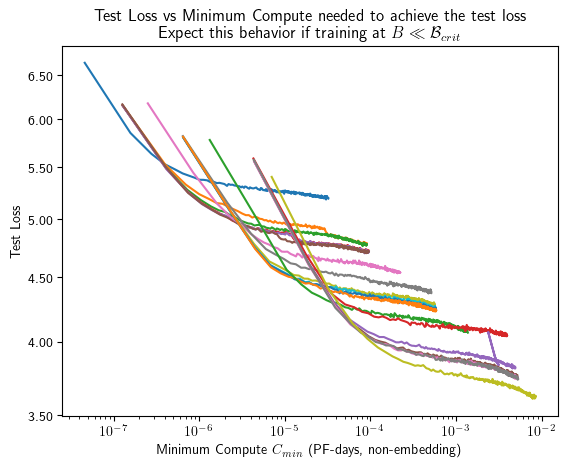

In [276]:
## Obtaining loss v Cmin data and plotting the curves


# define critical batch and minimum compute
def Bcrit(L):
    return Bstar / L ** (1 / alpha_B)


def Cmin(C, L, B=2**19):
    return C / (1 + B / Bcrit(L))


# recall loss_v_C is a dict with keys = (N, D) to specify a run, val = tuple of lists ([..], [..])
# The first list contains values of compute C, the second list contains losses
# we define a new dict loss_v_Cmin with the same structure, with C values replaced with those of Cmin.
loss_v_Cmin = {
    (N, D): ([Cmin(compute, loss) for (compute, loss) in zip(computes, losses)], losses)
    for (N, D), (computes, losses) in loss_v_C.items()
}

for (N, D), (computes, losses) in sorted(loss_v_Cmin.items()):
    plt.plot(computes, losses)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Minimum Compute $C_{min}$ (PF-days, non-embedding)")
plt.ylabel("Test Loss")
plt.title(
    "Test Loss vs Minimum Compute needed to achieve the test loss\n"
    "Expect this behavior if training at $B \ll \mathcal{B}_{crit}$"
)
plt.yticks(np.arange(3.5, 7.0, 0.5))
plt.gca().yaxis.set_major_formatter(FormatStrFormatter("%.2f"))
plt.show()

In [277]:
## finding scaling laws L(C) and Nopt(C)

# minloss_v_Cmin is a dict with key=Cmin, val=minimum loss achieved with that Cmin.
# Nopts_v_Cmin is a dict with key=Cmin, val=optimal value of N for that Cmin.
minloss_v_Cmin, Nopts_v_Cmin = {}, {}
for (N, D), (Cs, losses) in loss_v_Cmin.items():
    for C, loss in zip(Cs, losses):
        if C not in minloss_v_Cmin:
            minloss_v_Cmin[C] = loss
            Nopts_v_Cmin[C] = N
        else:
            if loss < minloss_v_Cmin[C]:
                minloss_v_Cmin[C] = loss
                Nopts_v_Cmin[C] = N

# Get points on the convex hull of minloss vs Cmin plot.
points = np.array([(C, minloss) for C, minloss in minloss_v_Cmin.items()])
hull_points = sorted(
    list(
        set(
            [
                tuple(points[simplex[i]])
                for i in [0, 1]
                for simplex in ConvexHull(points).simplices
            ]
        )
    )
)

## Train a Linear Regression model on (C, minloss) points on the convex hull
# first, obtain x and y coordinates for points on the convex hull, restricting to range 1e-5 < C < 1e-3
hull_Cs = [C for (C, _) in hull_points if 2e-7 < C < 1e-4]
hull_losses = [loss for (C, loss) in hull_points if 2e-7 < C < 1e-4]
slope, intercept = linear_fit(np.log(hull_Cs), np.log(hull_losses))
alpha_Cmin, Cmin_c = -slope, np.exp(-intercept / slope)
print(f"Scaling law for L(Cmin): L(Cmin)=(Cmin/{Cmin_c:.2e})^{-alpha_Cmin:.4f}")

## Now train a Linear Regression model on (C, N_{opt}) using points on the convex hull
hull_Ns = [Nopts_v_Cmin[C] for C in hull_Cs]
slope, intercept = linear_fit(np.log(hull_Cs), np.log(hull_Ns))
p_Np, N_ep = slope, np.exp(intercept)
print(f"Scaling law for Nopt(Cmin): N(Cmin) = {N_ep:.2e} Cmin^{p_Np:.4f}")

Scaling law for L(Cmin): L(Cmin)=(Cmin/4.23e+06)^-0.0566
Scaling law for Nopt(Cmin): N(Cmin) = 4.27e+09 Cmin^0.7158


<Figure size 7680x5760 with 0 Axes>

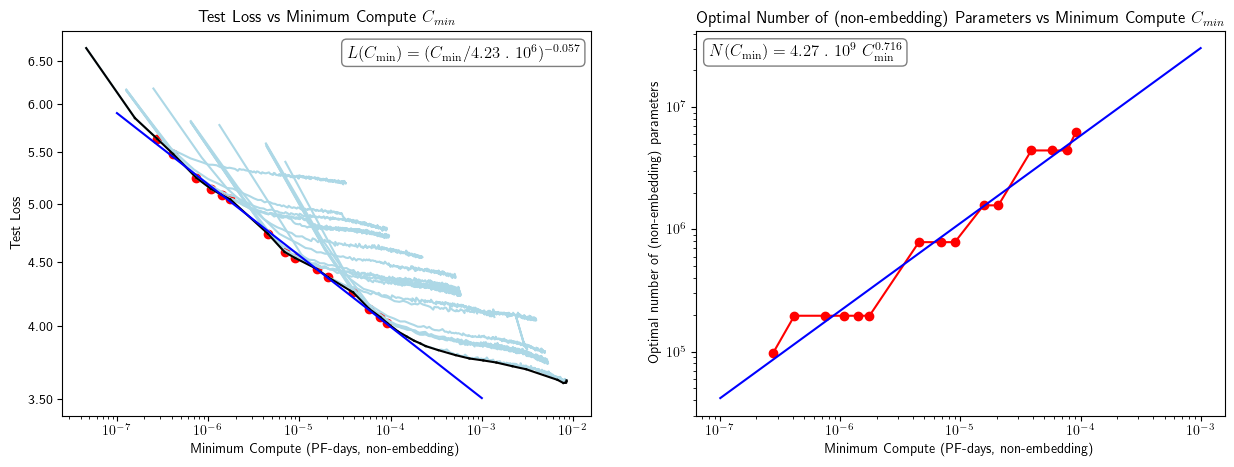

In [297]:
## plot the two fits to scaling laws
plt.figure(dpi=1200)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

####### ------ PLOT LOSS-C WITH AX1 --------- ###########

# plot all the loss-Cmin curves in light blue
for Cs, losses in loss_v_Cmin.values():
    ax1.plot(Cs, losses, color="lightblue")

# plot all the simplices in black
for simplex in ConvexHull(points).simplices[1:]:
    ax1.plot(points[simplex, 0], points[simplex, 1], color="black")

# plot all points used for the linear fit in red
ax1.scatter(hull_Cs, hull_losses, color="red")

# plot the linear fit in blue
domain = [10 ** (-n) for n in range(3, 8)]
ax1.plot(domain, (Cmin_c / np.array(domain)) ** alpha_Cmin, "-", color="blue")

####### ------ PLOT NOPT-C WITH AX1 --------- ###########
# plot all points used for linear fit in red
ax2.plot(hull_Cs, hull_Ns, "-o", color="red")

# plot the linear fit in blue
ax2.plot(domain, N_ep * (np.array(domain) ** p_Np), "-", color="blue")

##### --------- SETTING CONFIGURATIONS -------- ############

textLCmin = "$L(C_{{\min}}) = (C_{{\min}}/{0} \ . \ 10^{{{1}}})^{{{2}}}$".format(
    *f"{Cmin_c:.2e}".split("e+0") + [f"{-alpha_Cmin:.3f}"]
)
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_xlabel("Minimum Compute (PF-days, non-embedding)")
ax1.set_ylabel("Test Loss")
ax1.set_yticks(np.arange(3.5, 7.0, 0.5))
ax1.yaxis.set_major_formatter(FormatStrFormatter("%.2f"))
ax1.text(
    3.3e-5,
    6.7,
    textLCmin,
    verticalalignment="top",
    fontsize=12,
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.5),
)
ax1.set_title("Test Loss vs Minimum Compute $C_{min}$")

textNCmin = "$N(C_{{\min}}) = {0} \ . \ 10^{{{1}}} \ C_{{\min}}^{{{2}}}$".format(
    *f"{N_ep:.2e}".split("e+0") + [f"{p_Np:.3f}"]
)
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_xlabel("Minimum Compute (PF-days, non-embedding)")
ax2.set_ylabel("Optimal number of (non-embedding) parameters")
ax2.text(
    8e-8,
    3.3e7,
    textNCmin,
    verticalalignment="top",
    fontsize=12,
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.5),
)
ax2.set_title(
    "Optimal Number of (non-embedding) Parameters vs Minimum Compute $C_{min}$"
)

# plt.savefig("./assets/Kaplan_Cmin.png")
# save each subplot separately
extent = ax1.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig("./assets/Kaplan_LCmin.png", bbox_inches=extent.expanded(1.2, 1.25))

# save each subplot separately
extent = ax2.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig("./assets/Kaplan_NCmin.png", bbox_inches=extent.expanded(1.2, 1.25))

plt.show()

### Scaling Law with Parameter Count and Number of Training Steps

Contrary to the situation in the previous section, we may choose to train at a batch size much larger than the critical batch size. This setting provides maximal time-efficiency (at the cost of compute-efficiency). The minimum number of training steps $S_{\text{min}}$ needed to obtain a specified value of test loss $L$ is related to the number of steps $S$ at batch size $B = 2^{19}$ as

\begin{equation}
S_{\text{min}}(S) = \frac{S}{1+B_{\text{crit}}(L)/B}
\end{equation}

In [1], a scaling law for the test loss as a function of $N$ and $S_{\text{min}}$ was proposed:

\begin{equation}
L(N, S_{\text{min}}) = \left(\frac{N_c}{N} \right)^{\alpha_N} +  \left(\frac{S_c}{S_{\text{min}}} \right)^{\alpha_S}
\end{equation}

where the dataset includes all training steps $S$ after the warmup period of the learning rate schedule. A comparison of our results to those of [1] is as follows. 

<center>

|                   | $N_c$ | $\alpha_N$ | $S_c$ | $\alpha_S$ | 
| :---------------- | :------: | ----: | :------: | ----: |
| Kaplan et al.        |   $6.5 \times 10^{13}$   | $0.077$ |   $2.1 \times 10^{3}$  | $0.76$ |
| My results           |  $3.81 \times 10^{13}$  | $0.082$ |  $7.8 \times 10^{2}$   | $0.59$ 

</center>

We remark that we found it hard to find a good fit to $L(N, S)$ when simultaneously solving for all four variables $N_c$, $\alpha_N$, $S_c$, and $\alpha_S$. We obtained better results when we solved only for $S_c$ and $\alpha_S$, while using the values for $N_c$ and $\alpha_N$ found already in the fit to $L(N)$. The inability to find a good solution for all four variables could be because of a combination of the following reasons:

1. *Lack of enough data.* We trained only seven models that could be used to check the trend in $L(N, S)$. In contrast, the authors of [1] trained a much larger number of models.

2. *Range of values of $N$*. We experimented with models of much smaller size when compared to [1]. One may expect to get much better fits to $L(N, S)$ if one includes models of larger sizes. (See Figure 4 (Right) in [1] where the trend in data points for larger models seem to have been captured better than smaller models.)

3. *Algorithm used to find the fit*. We used scipy.optimize.curve_fit to fit $L(N, S)$ to data, which uses non-linear least squares to fit the function. Perhaps, a different algorithm would do a better job compared to this algorithm.

Scaling law with N, S: L(N, S)=(N/3.81e+13)^-0.0823 + (S/7.78e+02)^-0.5937


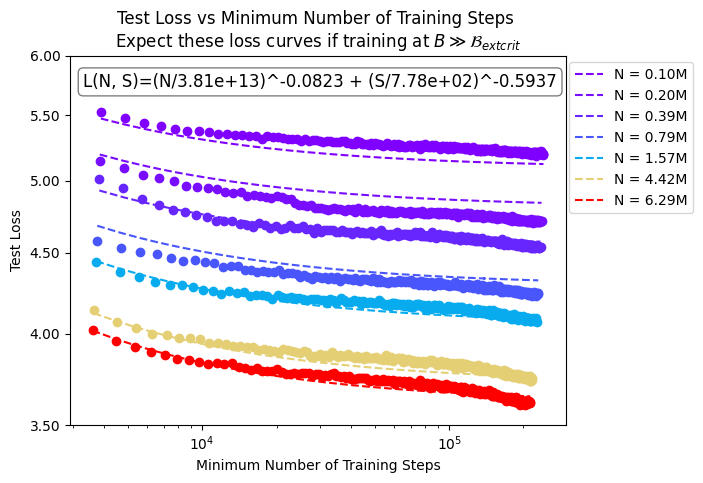

In [464]:
## collect all data, and fit to L(N, S)
# define Smin
def Smin(S, L, B=524288):
    return S / (1 + Bcrit(L) / B)


# LNS_data is a dict, key=N, val=dict with keys Smins, losses, val=list of Smins, losses
LNS_data = {
    run.config["N"]: {
        "Smins": [Smin(row["iter"], row["val/loss"]) for row in run.scan_history()][4:],
        "losses": [row["val/loss"] for row in run.scan_history()][4:],
    }
    for run in runs
    if run.config["scale_N"]
}


# define L(N, Smin)
def L(input, S_c, alpha_S):
    N, Smin = input
    N_term = np.sign(N_c / N) * (np.abs(N_c / N)) ** alpha_N
    S_term = np.sign(S_c / Smin) * (np.abs(S_c / Smin)) ** alpha_S
    return N_term + S_term


# Separate out Ns, Smins and losses to
Ns, Smins, losses = [], [], []
for N, losses_v_Smins in LNS_data.items():
    for key, val in losses_v_Smins.items():
        if key == "Smins":
            Ns.extend([N] * len(val))
            Smins.extend(val)
        if key == "losses":
            losses.extend(val)

(S_c, alpha_S), _ = curve_fit(
    L, (Ns, Smins), losses, maxfev=500000, p0=[2.1e3, 0.76]  # inputs  # outputs
)
textLNS = f"L(N, S)=(N/{N_c:.2e})^{-alpha_N:.4f} + (S/{S_c:.2e})^{-alpha_S:.4f}"
print(f"Scaling law with N, S: {textLNS}")

# Plot data points and L(N, S) fit
cmap = plt.cm.rainbow
norm = matplotlib.colors.Normalize(vmin=min(LNS_data.keys()), vmax=max(LNS_data.keys()))
for N, losses_v_Smins in sorted(LNS_data.items()):
    Smins, losses = losses_v_Smins["Smins"], losses_v_Smins["losses"]
    plt.plot(Smins, losses, "o", color=cmap(norm(N)))
    fit_output = L([N, Smins], S_c, alpha_S)
    plt.plot(Smins, fit_output, "--", label=f"N = {N/1e6:.2f}M", color=cmap(norm(N)))

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Minimum Number of Training Steps")
plt.ylabel("Test Loss")
plt.title(
    "Test Loss vs Minimum Number of Training Steps \n"
    "Expect these loss curves if training at $B \gg \mathcal{B}_{\text{crit}}$"
)
plt.yticks(np.arange(3.5, 6.5, 0.5))
plt.gca().yaxis.set_major_formatter(FormatStrFormatter("%.2f"))
plt.legend(loc="upper right", bbox_to_anchor=(1.27, 1.0))
plt.text(
    3.3e3,
    5.85,
    textLNS,
    verticalalignment="top",
    fontsize=12,
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.5),
)
plt.show()

### Optimal Performance and Allocation of Budget

In the previous two sections, we have obtained scaling laws with respect to minimum compute and minimum number of training steps, capturing behavior of language models if trained at batch sizes much smaller than and much bigger than the critical batch size respectively. We have also discovered how we must scale the number of (non-embedding) parameters as we get more compute for the most efficient use of this compute. 

Now we ask and answer the following important question: how must we scale the training batch size and the number of training steps as we get more compute? This question is natural once we remember that compute depends on three variables ($C=6NBS$) and while we know how the model size must scale with compute ($N \propto C_{\text{min}}^{0.72}$), we do not know how the other two variables must scale. 

We recall that the minimum compute to obtain a test loss is, by definition, $6N$ times the minimum number of training examples $E_{\text{min}}$ needed to achieve that loss. Through the definition of $\mathcal{B}_{\text{crit}}$, $E_{\text{min}} = \mathcal{B}_{\text{crit}} S_{\text{min}}$, and hence,
$C_{\text{min}} = 6 N \mathcal{B}_{\text{crit}} S_{\text{min}}$. Now, $\mathcal{B}_{\text{crit}} \propto L^{-1/\alpha_B}$ and $L \propto C_{\text{min}}^{-\alpha_C^{\text{min}}}$, so 
$\mathcal{B}_{\text{crit}} \propto C_{\text{min}}^{\alpha_C^{\text{min}}/\alpha_B} \propto C_{\text{min}}^{0.24}$. It follows that $S_{\text{min}} \propto C_{\text{min}}^{0.04}$. That is, as compute is increased 100x, $S_{\text{min}}$ stays almost the same, $\mathcal{B}_{\text{crit}}$ increases 3x, and model size increases 27x. This is a remarkable result, implying that most of the new compute must go into increasing the model size, and some of it must go into increasing the batch size. But we do not need to train our models for significantly longer!

### References

[1]. Kaplan, J., McCandlish, S., Henighan, T., Brown, T. B., Chess, B., Child, R., Gray, S., Radford, A., Wu, J., and Amodei, D. Scaling laws for neural language models. arXiv preprint arXiv:2001.08361, 2020.

[2]. McCandlish, S., Kaplan, J., Amodei, D., and Team, O. D. An empirical model of large-batch training. arXiv preprint arXiv:1812.06162, 2018.